# Проект: Нейросеть для автодополнения текстов

## Описание
Этот проект сравнивает две модели для автодополнения текста:
1. **LSTM модель** - обучена с нуля на датасете Sentiment140
2. **DistilGPT2** - предобученная трансформерная модель

In [ ]:
!git clone https://github.com/A1ienSword/text-autocomplete.git
%cd text-autocomplete/

In [ ]:
#%pip install -r requirements.txt
%pip install evaluate

In [ ]:
from datetime import datetime
import json
import logging
import random
import yaml
from pathlib import Path
from typing import Any, Dict, List, Tuple
import numpy as np
import pandas as pd
from transformers import AutoTokenizer
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (14, 6)

from src.data_utils import process_dataset, split_data, get_config
from src.next_token_dataset import NextTokenDataset, collate_fn
from src.lstm_model import LSTMModel
from src.distil_gpt2_model import DistilGPT2
from src.lstm_train import train_model
from src.eval_lstm import evaluate_rouge
from src.eval_transformer_pipeline import compare_models


c:\Yandex\text-autocomplete\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-11-06 10:03:27,086 - datasets - INFO - PyTorch version 2.7.1 available.


In [ ]:
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s'
)
logger = logging.getLogger(__name__)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
logger.info(f'Используется устройство: {device}')
logger.info(f'PyTorch версия: {torch.__version__}')

config = get_config(Path('./configs/config.yaml'))
logger.info('Конфигурация загружена')

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)

logger.info(f'Random seed установлен: {SEED}')

2025-11-06 10:03:36,038 - __main__ - INFO - Используется устройство: cpu
2025-11-06 10:03:36,040 - __main__ - INFO - PyTorch версия: 2.7.1+cpu
2025-11-06 10:03:36,048 - src.data_utils - INFO - Конфигурация успешно загружена из configs\config.yaml
2025-11-06 10:03:36,050 - __main__ - INFO - Конфигурация загружена
2025-11-06 10:03:36,068 - __main__ - INFO - Random seed установлен: 42


# Этап 1: Подготовка данных

## Процесс:
1. Загрузка датасета Sentiment140
2. Предобработка текстов (очистка, нормализация)
3. Токенизация с использованием BertTokenizer
4. Разбиение на train/val/test
5. Создание PyTorch Dataset'ов и DataLoader'ов

In [ ]:
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
logger.info(f'Размер словаря: {tokenizer.vocab_size}')

logger.info('Начало обработки датасета...')
processed_texts = process_dataset(
    config_path='./configs/config.yaml',
    tokenizer=tokenizer,
    force_reprocess=False
)

logger.info(f'Всего обработано текстов: {len(processed_texts)}')
print(f'Пример обработанного текста (первые 10 токенов):')
print(f'{processed_texts[0][:10]}')

2025-11-06 10:03:39,755 - __main__ - INFO - Размер словаря: 30522
2025-11-06 10:03:39,759 - __main__ - INFO - Начало обработки датасета...
2025-11-06 10:03:39,765 - src.data_utils - INFO - Конфигурация успешно загружена из configs\config.yaml
2025-11-06 10:03:39,766 - src.data_utils - INFO - Загрузка уже обработанных данных по пути: data\dataset_processed.json
2025-11-06 10:03:39,769 - __main__ - INFO - Всего обработано текстов: 100


Пример обработанного текста (первые 10 токенов):
['aw', '##w', '##w', ',', 'that', "'", 's', 'a', 'bum', '##mer']


In [ ]:
train_texts, val_texts, test_texts = split_data(
    processed_texts,
    config_path='./configs/config.yaml'
)

print('=== Размеры выборок ===')
print(f'Train set: {len(train_texts)} примеров ({len(train_texts)/len(processed_texts)*100:.1f}%)')
print(f'Val set:   {len(val_texts)} примеров ({len(val_texts)/len(processed_texts)*100:.1f}%)')
print(f'Test set:  {len(test_texts)} примеров ({len(test_texts)/len(processed_texts)*100:.1f}%)')

train_lengths = [len(t) for t in train_texts]
val_lengths = [len(t) for t in val_texts]
test_lengths = [len(t) for t in test_texts]

print('=== Статистика длин по выборкам ===')
for name, lengths in [('Train', train_lengths), ('Val', val_lengths), ('Test', test_lengths)]:
    print(f'{name:<10}: mean={np.mean(lengths):.2f}, median={np.median(lengths):.2f}, max={max(lengths)}')

2025-11-06 10:03:41,762 - src.data_utils - INFO - Конфигурация успешно загружена из configs\config.yaml
2025-11-06 10:03:41,764 - src.data_utils - INFO - Разбиение 100 примеров на train/val/test
2025-11-06 10:03:41,768 - src.data_utils - INFO - Train: 80, Val: 10, Test: 10
2025-11-06 10:03:41,772 - src.data_utils - INFO - Удаление существующего файла: data\train.json
2025-11-06 10:03:41,782 - src.data_utils - INFO - Данные сохранены в data\train.json (80 записей)
2025-11-06 10:03:41,786 - src.data_utils - INFO - Удаление существующего файла: data\val.json
2025-11-06 10:03:41,794 - src.data_utils - INFO - Данные сохранены в data\val.json (10 записей)
2025-11-06 10:03:41,798 - src.data_utils - INFO - Удаление существующего файла: data\test.json
2025-11-06 10:03:41,802 - src.data_utils - INFO - Данные сохранены в data\test.json (10 записей)


=== Размеры выборок ===
Train set: 80 примеров (80.0%)
Val set:   10 примеров (10.0%)
Test set:  10 примеров (10.0%)
=== Статистика длин по выборкам ===
Train     : mean=19.36, median=19.50, max=40
Val       : mean=19.20, median=22.00, max=31
Test      : mean=14.50, median=12.00, max=29


In [ ]:
train_dataset = NextTokenDataset(train_texts, tokenizer)
val_dataset = NextTokenDataset(val_texts, tokenizer)
test_dataset = NextTokenDataset(test_texts, tokenizer)

print('=== Информация о Dataset ===')
print(f'Train dataset size: {len(train_dataset)}')
print(f'Val dataset size:   {len(val_dataset)}')
print(f'Test dataset size:  {len(test_dataset)}')


2025-11-06 10:03:44,349 - src.next_token_dataset - INFO - Dataset создан с 80 примерами
2025-11-06 10:03:44,351 - src.next_token_dataset - INFO - Dataset создан с 10 примерами
2025-11-06 10:03:44,353 - src.next_token_dataset - INFO - Dataset создан с 10 примерами


=== Информация о Dataset ===
Train dataset size: 80
Val dataset size:   10
Test dataset size:  10


In [ ]:
pad_token_id = tokenizer.pad_token_id or 0
batch_size = config['training']['batch_size']

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=lambda b: collate_fn(b, pad_token_id)
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=lambda b: collate_fn(b, pad_token_id)
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=lambda b: collate_fn(b, pad_token_id)
)

print('=== DataLoaderы созданы ===')
print(f'Train batches: {len(train_loader)}')
print(f'Val batches:   {len(val_loader)}')
print(f'Test batches:  {len(test_loader)}')
print(f'Batch size:    {batch_size}')
print(f'Pad token ID:  {pad_token_id}')

sample_batch = next(iter(train_loader))
print(f'=== Пример батча ===')
print(f'Input IDs shape:  {sample_batch["input_ids"].shape}')
print(f'Labels shape:     {sample_batch["labels"].shape}')

=== DataLoaderы созданы ===
Train batches: 2
Val batches:   1
Test batches:  1
Batch size:    64
Pad token ID:  0
=== Пример батча ===
Input IDs shape:  torch.Size([64, 37])
Labels shape:     torch.Size([64, 37])


# Этап 2: Создание и инициализация модели
## Архитектура LSTM модели:
```
Input (token IDs)
    ↓
Embedding Layer (256 dim)
    ↓
Dropout (0.1)
    ↓
LSTM (3 layers, 256 hidden, dropout=0.2)
    ↓
Layer Normalization (опционально)
    ↓
Fully Connected (vocab_size)
    ↓
Output (logits)
```

## Параметры:
- **Embedding dimension**: 256 (размер эмбеддингов)
- **Hidden dimension**: 256 (размер скрытого состояния LSTM)
- **Number of layers**: 3 (глубина сети)
- **Dropout**: 0.2 (регуляризация)
- **Vocab size**: 30522 (BERT токенайзер)

In [ ]:
model = LSTMModel(
    vocab_size=tokenizer.vocab_size,
    embed_dim=config['model']['embed_dim'],
    hidden_dim=config['model']['hidden_dim'],
    num_layers=config['model']['num_layers'],
    pad_token_id=pad_token_id,
    dropout=config['model']['dropout'],
    embed_dropout=config['model'].get('embed_dropout', 0.1),
    bidirectional=config['model'].get('bidirectional', False),
    use_layer_norm=config['model'].get('use_layer_norm', False)
)
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print('\n=== Информация о модели ===')
print(f'Total parameters:     {total_params:,}')
print(f'Trainable parameters: {trainable_params:,}')
print(f'Model size:           {total_params * 4 / (1024**2):.2f} MB')
model = model.to(device)
print(f'Модель перемещена на устройство: {device}')

2025-11-06 10:03:51,539 - src.lstm_model - INFO - LSTMModel создана: vocab=30522, embed=256, hidden=256, layers=3, bidirectional=False



=== Информация о модели ===
Total parameters:     17,236,794
Trainable parameters: 17,236,794
Model size:           65.75 MB
Модель перемещена на устройство: cpu


# Этап 3: Обучение модели

## Процесс обучения:
1. Forward pass через батчи
2. Вычисление loss (CrossEntropyLoss)
3. Backward pass и обновление весов
4. Валидация на каждой эпохе
5. Early stopping если нет улучшений
6. Learning rate scheduling

2025-11-06 10:03:55,094 - src.lstm_train - INFO - Начало обучения на 10 эпох
Epoch 1/10 [Val]: 100%|██████████| 1/1 [00:00<00:00,  4.27it/s]
2025-11-06 10:04:08,397 - src.lstm_train - INFO - Epoch 1/10 - Train Loss: 10.3127, Val Loss: 10.2870, LR: 0.001000
2025-11-06 10:04:08,974 - src.lstm_train - INFO - Сохранена лучшая модель (val_loss: 10.2870)
Epoch 2/10 [Val]: 100%|██████████| 1/1 [00:00<00:00,  4.29it/s]
2025-11-06 10:04:17,891 - src.lstm_train - INFO - Epoch 2/10 - Train Loss: 10.2639, Val Loss: 10.2138, LR: 0.001000
2025-11-06 10:04:18,422 - src.lstm_train - INFO - Сохранена лучшая модель (val_loss: 10.2138)
Epoch 3/10 [Val]: 100%|██████████| 1/1 [00:00<00:00,  4.25it/s]
2025-11-06 10:04:24,804 - src.lstm_train - INFO - Epoch 3/10 - Train Loss: 10.1498, Val Loss: 9.8765, LR: 0.001000
2025-11-06 10:04:25,341 - src.lstm_train - INFO - Сохранена лучшая модель (val_loss: 9.8765)
Epoch 4/10 [Val]: 100%|██████████| 1/1 [00:00<00:00,  2.13it/s]
2025-11-06 10:04:31,826 - src.lstm_trai

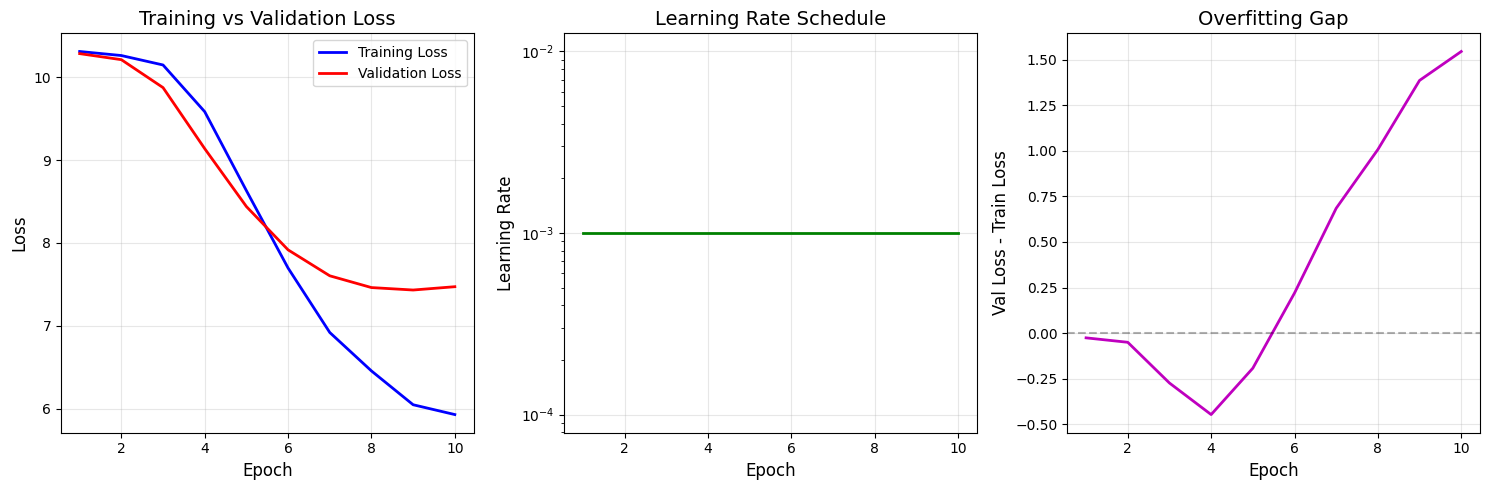

2025-11-06 10:05:12,834 - src.lstm_train - INFO - Обучение завершено. Лучшая модель: models\best_model.pt


In [ ]:
trained_model = train_model(
    model,
    train_loader,
    val_loader,
    tokenizer,
    device,
    epochs=config['training']['epochs'],
    lr=config['training']['optimizer']['lr'],
    weight_decay=config['training']['optimizer']['weight_decay'],
    pad_token_id=pad_token_id,
    save_dir = config['training']['save_dir'],
    patience = config['training']['early_stopping']['patience']
)

# Этап 4: Оценка моделей
## Метрики качества:

### ROUGE метрики
- **ROUGE-1**: Unigram overlap (совпадение одиночных слов)
- **ROUGE-2**: Bigram overlap (совпадение пар слов)
- **ROUGE-L**: Longest Common Subsequence (самая длинная общая последовательность)


In [ ]:
print('ОЦЕНКА LSTM МОДЕЛИ НА ТЕСТОВОМ НАБОРЕ')
print('='*60)

lstm_test_rouge = evaluate_rouge(
    model=trained_model,
    dataloader=test_loader,
    tokenizer=tokenizer,
    device=device,
    pad_token_id=pad_token_id,
    max_samples=2000,
    cutoff_ratio=0.75,
    temperature=0.8,
    top_k=20,
)

lstm_test_rouge1 = float(lstm_test_rouge['rouge1']) if isinstance(lstm_test_rouge['rouge1'], (int, float)) else lstm_test_rouge['rouge1']
lstm_test_rouge2 = float(lstm_test_rouge['rouge2']) if isinstance(lstm_test_rouge['rouge2'], (int, float)) else lstm_test_rouge['rouge2']
lstm_test_rougeL = float(lstm_test_rouge['rougeL']) if isinstance(lstm_test_rouge['rougeL'], (int, float)) else lstm_test_rouge['rougeL']

print(f'\nРезультаты LSTM на тесте:')
print(f'  ROUGE-1: {lstm_test_rouge1:.4f}')
print(f'  ROUGE-2: {lstm_test_rouge2:.4f}')
print(f'  ROUGE-L: {lstm_test_rougeL:.4f}')

2025-11-06 10:05:16,781 - src.eval_lstm - INFO - Оценка модели на 2000 примерах...


ОЦЕНКА LSTM МОДЕЛИ НА ТЕСТОВОМ НАБОРЕ


Evaluating ROUGE: 100%|██████████| 1/1 [00:00<00:00,  1.86it/s]
2025-11-06 10:05:21,626 - absl - INFO - Using default tokenizer.
2025-11-06 10:05:21,958 - src.eval_lstm - INFO - 
Результаты ROUGE:
2025-11-06 10:05:21,958 - src.eval_lstm - INFO -   ROUGE-1: 0.0
2025-11-06 10:05:21,958 - src.eval_lstm - INFO -   ROUGE-2: 0.0
2025-11-06 10:05:21,967 - src.eval_lstm - INFO -   ROUGE-L: 0.0



Результаты LSTM на тесте:
  ROUGE-1: 0.0000
  ROUGE-2: 0.0000
  ROUGE-L: 0.0000


In [ ]:
print('ЗАГРУЗКА ПРЕДОБУЧЕННОЙ МОДЕЛИ DISTILGPT2')
print('='*60)

baseline = DistilGPT2(device='cuda' if torch.cuda.is_available() else 'cpu')

print('Модель DistilGPT2 успешно загружена')

2025-11-06 10:05:23,804 - src.distil_gpt2_model - INFO - Загрузка предобученной модели distilgpt2...


ЗАГРУЗКА ПРЕДОБУЧЕННОЙ МОДЕЛИ DISTILGPT2


In [ ]:
print('ОЦЕНКА DISTILGPT2 НА ТЕСТОВОМ НАБОРЕ')
print('='*60)

baseline_test_rouge = baseline.evaluate_rouge(
    val_texts=test_texts,  # Используем тестовый набор
    max_samples=2000,
    max_new_tokens=20,
    cutoff_ratio=0.75,
    do_sample=True,
    top_k=10,
    top_p=0.8,
    temperature=0.5,
    show_examples=True,
    num_examples=5
)

baseline_test_rouge1 = float(baseline_test_rouge['rouge1']) if isinstance(baseline_test_rouge['rouge1'], (int, float)) else baseline_test_rouge['rouge1']
baseline_test_rouge2 = float(baseline_test_rouge['rouge2']) if isinstance(baseline_test_rouge['rouge2'], (int, float)) else baseline_test_rouge['rouge2']
baseline_test_rougeL = float(baseline_test_rouge['rougeL']) if isinstance(baseline_test_rouge['rougeL'], (int, float)) else baseline_test_rouge['rougeL']

print(f'\nРезультаты DistilGPT2 на тесте:')
print(f'  ROUGE-1: {baseline_test_rouge1:.4f}')
print(f'  ROUGE-2: {baseline_test_rouge2:.4f}')
print(f'  ROUGE-L: {baseline_test_rougeL:.4f}')

In [ ]:
compare_models(lstm_test_rouge,baseline_test_rouge)

2025-11-06 01:13:33,736 - src.eval_transformer_pipeline - INFO - 
2025-11-06 01:13:33,738 - src.eval_transformer_pipeline - INFO - СРАВНЕНИЕ МОДЕЛЕЙ
2025-11-06 01:13:33,739 - src.eval_transformer_pipeline - INFO - ============================================================
2025-11-06 01:13:33,741 - src.eval_transformer_pipeline - INFO - Модель               ROUGE-1      ROUGE-2      ROUGE-L     
2025-11-06 01:13:33,742 - src.eval_transformer_pipeline - INFO - ------------------------------------------------------------
2025-11-06 01:13:33,743 - src.eval_transformer_pipeline - INFO - LSTM                 0.0000       0.0000       0.0000      
2025-11-06 01:13:33,747 - src.eval_transformer_pipeline - INFO - DistilGPT2           0.0000       0.0000       0.0000      
2025-11-06 01:13:33,749 - src.eval_transformer_pipeline - INFO - ------------------------------------------------------------
2025-11-06 01:13:33,752 - src.eval_transformer_pipeline - INFO - 
Лучшая модель: LSTM
2025-11-06 0

{'best_model': 'LSTM',
 'improvement': np.float64(0.0),
 'improvement_percent': np.float64(0.0),
 'lstm_scores': {'rouge1': np.float64(0.0),
  'rouge2': np.float64(0.0),
  'rougeL': np.float64(0.0),
  'rougeLsum': np.float64(0.0)},
 'transformer_scores': {'rouge1': np.float64(0.0),
  'rouge2': np.float64(0.0),
  'rougeL': np.float64(0.0),
  'rougeLsum': np.float64(0.0)}}